# Ejercicio Práctica 7: curvas de aprendizaje en Machine Learning: the California housing problem 

Una curva de aprendizaje en Machine Learning simplemente es una gráfica donde se representa las epochs (eje horizontal) frente a la función objetivo (eje vertical).

En este ejercicio vermos cómo usar las curvas de aprendizaje para analizar el comportamiento de varios algoritmos de optimización. Para ello, estudiaremos el llamado **California housing problem**, el cual es un problema de regresión que consiste en predecir el valor que debe tener una casa en California dependiendo de varias características. La descripción de los datos es la siguiente:

**Labels**

'MedHouseVal' = Mediana de viviendas para familias en una manzana (medido en dólares estadounidenses)

**Features**

'MedInc' = Media de ingresos para grupos familiares en una manzana (medido en decenas de miles de dólares estadounidenses)

'HouseAge' = Antigüedad media de una casa 

'AveRooms' = Media de habitaciones en un bloque de casas

'AveBedrms' = Media de habitaciones en un barrio

'Population' = Cantidad total de personas que residen en un barrio

'AveOccup' = media de casa ocupadas

'Latitude' = latitud geográfica de la casa

'Longitude' = longitud geográfica de la casa

Estas dos últimas características hacen referencia a la localización de la casa

Los datos están almacenados es una basa de datos de **scikitlearn**. Con las siguientes líneas de código los cargamos.

In [17]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()

housing


{'data': array([[   8.3252    ,   41.        ,    6.98412698, ...,    2.55555556,
           37.88      , -122.23      ],
        [   8.3014    ,   21.        ,    6.23813708, ...,    2.10984183,
           37.86      , -122.22      ],
        [   7.2574    ,   52.        ,    8.28813559, ...,    2.80225989,
           37.85      , -122.24      ],
        ...,
        [   1.7       ,   17.        ,    5.20554273, ...,    2.3256351 ,
           39.43      , -121.22      ],
        [   1.8672    ,   18.        ,    5.32951289, ...,    2.12320917,
           39.43      , -121.32      ],
        [   2.3886    ,   16.        ,    5.25471698, ...,    2.61698113,
           39.37      , -121.24      ]]),
 'target': array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894]),
 'frame': None,
 'target_names': ['MedHouseVal'],
 'feature_names': ['MedInc',
  'HouseAge',
  'AveRooms',
  'AveBedrms',
  'Population',
  'AveOccup',
  'Latitude',
  'Longitude'],
 'DESCR': '.. _california_housing_dataset:\n

![En este gráfico puedes ver la distribución de casas y precios](..\data\california_housing.png)

Las siguientes líneas de código hacen la separación entre datos de entrenamiento, validación y test.

También normalizan los datos. Esta es una técnica usual en Machine Learning que trata de evitar sesgos en los datos de partida. Para cada una de las 8 columnas de características, la normalización de los datos se hace de manera stándard del siguiente modo:

1) Se calculan la media $\mu_j$ y la desviación típica $\sigma_j$, $1\leq j\leq 8$.

2) Si $x^j$ denota la columna $j-$ésima, entonces dicha columna se transforma en 

$$
\hat{x}^j = \frac{x^j - \mu_j}{\sigma_j}
$$

con lo cual los nuevos datos tienen media cero y varianza 1.

Las siguientes líneas de código hacen el trabajo.

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)


Nótese que ha aparecido un nuevo conjunto de datos **X_valid**. Se trata de un subconjunto de datos que se usa para tunear hiperparámetros del modelo, por ejemplo el número de capas ocultas, neuronas por capa, etc. Por tanto, **X_valid** se usa durante el entrenamiento. Es un subconjunto de los datos de entrenamiento.

Imprimer por pantalla las dimensiones de los conjuntos **X_train**, **X_val** y **X_test**.

In [19]:
# Completar aquí
print(f"Dimesiones de X_train: {X_train.shape}")
print(f"Dimensiones de X_valid: {X_valid.shape}")
print(f"Dimesiones de X_test: {X_test.shape}")
# --------------------


Dimesiones de X_train: (11610, 8)
Dimensiones de X_valid: (3870, 8)
Dimesiones de X_test: (5160, 8)


A continuación cargamos **tensorflow** y **numpy**. Asímismo, fijamos semillas en **numpy** y **tensorflow** para que la reproducción de procesos aleatorios de el mismo resultado.

In [20]:
import numpy as np
import tensorflow as tf

In [21]:
np.random.seed(42)
tf.random.set_seed(42)

A continuación, construimos el modelo de predicción (la red neuronal). Se trata de un MultiLayerPerceptron (MLP) con $8$ canales de entrada, una sóla capa oculta de $30$ neuronas, y una salida escalar. Es decir
$$
NN(x,\theta) =  \sum_{j=1}^{30} a_j\sigma \left(\omega x + b\right)_j + b_{output}, \quad \theta = (\omega; b) 
$$
donde $\sigma$ es la función de activación, la cual se aplica componente a componente, $\omega$ es una matriz de tamaño $30\times 8$, $b$ es un vector bias de tamaño $30$, y $b_{output}$ es un bias de salida escalar. Por tanto, nuestro modelo tiene $30\times 8 + 30 + 30 +1 = 301 $ parámetros de entrenamiento.

In [22]:
from tensorflow import keras


In [23]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", kernel_initializer='glorot_uniform',
                        input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])
model.summary()

c:\Users\fcoja\.conda\envs\optim-2\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 30)             │           270 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 301 (1.18 KB)

 Trainable params: 301 (1.18 KB)

 Non-trainable params: 0 (0.00 B)

Explica con tus propias palabras lo que hacen las líneas de código de la celda anterior. Para ello consulta la  [API de Keras](https://keras.io/api/)

----
Este código crea un modelo de red neuronal con dos capas para hacer predicciones.

1. Primero, se define el modelo como una serie de capas que se conectan en orden.
2. La primera capa tiene 30 neuronas y usa una función que ayuda a que el modelo aprenda patrones más complejos. También se configura para que reciba los datos de entrada con la misma cantidad de características (columnas) que tiene nuestro conjunto de entrenamiento.
3. La segunda capa tiene solo 1 neurona y no usa ninguna función especial; esto indica que se espera un resultado en forma de número continuo (como un precio o una puntuación).

Finalmente, la última línea muestra un resumen del modelo, para ver cuántas capas y parámetros tiene en total, lo cual ayuda a entender mejor su estructura.

----

Configuramos el modelo para el entrenamiento. Elegimos como función objetivo (loss function) el error cuadrático medio, y como optimizador el gradiente estocástico sencillo learning rate = 0.01

In [24]:
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(learning_rate=1e-3))

Entrenamos el modelo con el [método fit](https://keras.io/api/models/model_training_apis/)

In [25]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - loss: 3.7705 - val_loss: 1.8186
Epoch 2/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step - loss: 0.8175 - val_loss: 1.1024
Epoch 3/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - loss: 0.7061 - val_loss: 0.8054
Epoch 4/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step - loss: 0.6590 - val_loss: 0.6671
Epoch 5/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step - loss: 0.6238 - val_loss: 0.5935
Epoch 6/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step - loss: 0.5953 - val_loss: 0.5500
Epoch 7/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step - loss: 0.5717 - val_loss: 0.5214
Epoch 8/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step - loss: 0.5522 - val_loss: 0.5018
Epoch 9/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step - loss: 0.5357 - val_loss: 0.4876
Epoch 10/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step - loss: 0.5220 - val_loss: 0.4775
Epoch 11/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step - loss: 0.5100 - val_loss: 0.4704
Epoch 12/20
363/363 ━━━━━━━━━

¿Se ha usado mini-batch en el método de gradiente estocástico anterior? En caso afirmativo, ¿cúantos datos contiene cada mini-batch?

Te puede ayudar a responder estas preguntas los resultados que obtienes de ejecutar la celda siguiente, que también has de explicar.

In [26]:
print(history.params)
print(history.history)

{'verbose': 'auto', 'epochs': 20, 'steps': 363}
{'loss': [2.1542274951934814, 0.7488600015640259, 0.6601737141609192, 0.6171107292175293, 0.5850968956947327, 0.5593091249465942, 0.5379423499107361, 0.5202820301055908, 0.5056182146072388, 0.4933406114578247, 0.48300713300704956, 0.4741726219654083, 0.4665394425392151, 0.4600991904735565, 0.4545760154724121, 0.4497837722301483, 0.4455758333206177, 0.44185692071914673, 0.4385075569152832, 0.4354493021965027], 'val_loss': [1.8185911178588867, 1.102372169494629, 0.8053810596466064, 0.6670575737953186, 0.5934996604919434, 0.5500391125679016, 0.5213832259178162, 0.5018448829650879, 0.48763036727905273, 0.4775126278400421, 0.47040340304374695, 0.46533650159835815, 0.46192383766174316, 0.4570315480232239, 0.45323246717453003, 0.45065951347351074, 0.44899430871009827, 0.44800058007240295, 0.44744744896888733, 0.44718265533447266]}


---

En el código, el método **`fit()`** de Keras usa mini-batch por defecto, incluso si no se especifica explícitamente. La cantidad de datos que contiene cada mini-batch está controlada por el parámetro **`batch_size`**, que no se ha definido en este caso. Si no se especifica, Keras utiliza un valor predeterminado **`batch_size=32`**.

Por lo tanto, sí, se ha utilizado mini-batch en el gradiente estocástico, y cada mini-batch contiene 32 datos.

---

A continuación nos ocupamos de analizar la evolución del algoritmo de optimización (training process).
Para ello usaremos los módulos **pandas** y **matplotlib** 

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

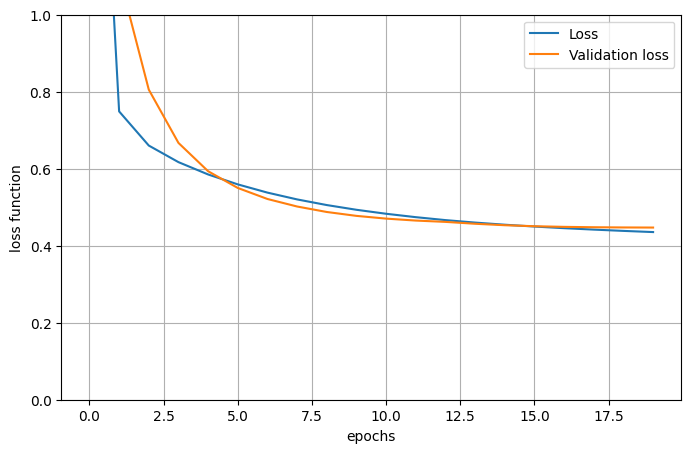

In [28]:
loss_history = pd.DataFrame(history.history)
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(loss_history['loss'], label='Loss')
ax.plot(loss_history['val_loss'], label='Validation loss')
ax.grid()
ax.set_ylim(0, 1)
ax.set_xlabel('epochs')
ax.set_ylabel('loss function')
ax.legend();

Finalmente, evaluamos el error cuadrático medio sobre los datos test con  [model.evaluate](https://keras.io/api/models/model_training_apis/) y hacemos predicciones sobre conjuntos de datos con [model.predict](https://keras.io/api/models/model_training_apis/)

In [29]:
mse_test = model.evaluate(X_test, y_test)
print(f"MSE_test = {mse_test}")
X_new = X_test[:3]
print(f"X_new = { X_new}")
y_pred = model.predict(X_new)
print(f"y_predict = {y_pred}")

162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step - loss: 0.4402
MSE_test = 0.43446826934814453
X_new = [[-1.15780104 -0.28673138 -0.49550877 -0.16618097 -0.02946012  0.38899735
   0.19374821  0.2870474 ]
 [-0.7125531   0.10880952 -0.16332973  0.20164652  0.12842117 -0.11818174
  -0.23725261  0.06215231]
 [-0.2156101   1.8491895  -0.57982788  0.18528489 -0.10429403 -0.67694905
   1.00890193 -1.4271529 ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
y_predict = [[0.5488222]
 [1.6651874]
 [3.520823 ]]


Para acabar la práctica, vamos a entrenar el modelo con otro algoritmo de optimización. Para ello:

1) Crea de nuevo el modelo y llámale **model_2**.

2) Configura el modelo de entrenamiento  **model_2** para lo cual debes elegir algún otro algoritmo de optimización (el que quieras) de los disponibles en el método **model.compile** 

3) Entrena **model_2** con mini-batches que contengan $64$ datos y para $50$ epochs. 

Los resultados que se muestran a continuación se corresponden con el algoritmo **Adam**.

In [30]:
# Completar aquí
model_2 = keras.models.Sequential()
model_2.add(keras.layers.Dense(30, activation="relu", kernel_initializer='glorot_uniform',
                               input_shape=X_train.shape[1:]))
model_2.add(keras.layers.Dense(1))

# Resumen del modelo
model_2.summary()

# Configurar el modelo con el optimizador Adam
model_2.compile(loss="mean_squared_error", optimizer=keras.optimizers.Adam())

# Entrenar el modelo con mini-batches de 64 datos y 50 epochs
history_2 = model_2.fit(X_train, y_train, epochs=50, 
                        batch_size=64, validation_data=(X_valid, y_valid))
# --------------------


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 30)             │           270 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 301 (1.18 KB)

 Trainable params: 301 (1.18 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.8653 - val_loss: 2.5515
Epoch 2/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step - loss: 0.8296 - val_loss: 1.0160
Epoch 3/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step - loss: 0.6473 - val_loss: 0.5954
Epoch 4/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step - loss: 0.5465 - val_loss: 0.4872
Epoch 5/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step - loss: 0.4914 - val_loss: 0.4409
Epoch 6/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step - loss: 0.4561 - val_loss: 0.4090
Epoch 7/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step - loss: 0.4338 - val_loss: 0.3801
Epoch 8/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step - loss: 0.4194 - val_loss: 0.3773
Epoch 9/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - loss: 0.4097 - val_loss: 0.3631
Epoch 10/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step - loss: 0.4028 - val_loss: 0.3631
Epoch 11/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step - loss: 0.3976 - val_loss: 0.3565
Epoch 12/50
182/182 ━━━━━━━━━━━━

Finalmente, dibuja las curvas de aprendizaje para tu modelo.

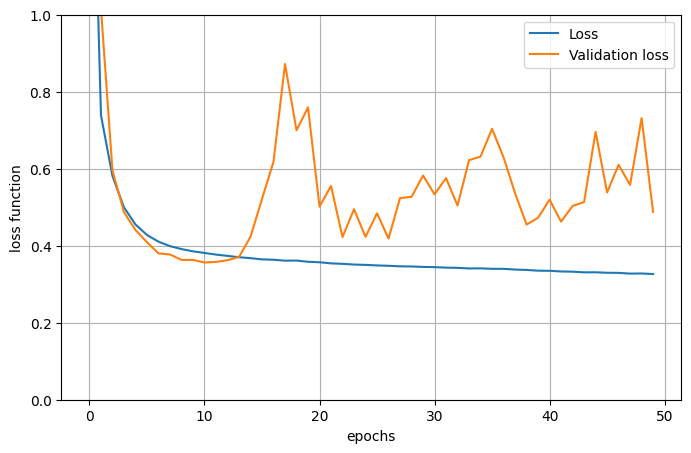

In [31]:
# Completar aquí
loss_history_2 = pd.DataFrame(history_2.history)
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(loss_history_2['loss'], label='Loss')
ax.plot(loss_history_2['val_loss'], label='Validation loss')
ax.grid()
ax.set_ylim(0, 1)
ax.set_xlabel('epochs')
ax.set_ylabel('loss function')
ax.legend()
# --------------------